source : https://jankrepl.github.io/creating-animations-with-MCMC/

In [1]:
import imcmc
import numpy as np

/opt/conda/lib/python3.9/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
class FakeTrace:
    """Multitrace holder to integrated simply with imcmc and pymc3 API"""
    
    def __init__(self, trace):
        self.chains = list(range(len(trace)))
        self.trace = trace

    def get_values(self, *args, chains=None, **kwargs):
        return self.trace[chains]

def rejection_sampling(image, samples):
    """Rejection sampling """
    
    image_pdf = image / image.sum()
    pdf_max = image_pdf.max()
    height, width = image_pdf.shape
    p_succes = 1 / (height * width * pdf_max)
    actual_samples = min(int(samples / p_succes), int(1e8))
    samples_height = np.random.randint(0, high=height, size=actual_samples)
    samples_width = np.random.randint(0, high=width, size=actual_samples)
    samples_uniform = np.random.uniform(0, 1, size=actual_samples)

    good_samples = [(h, w) for (h, w, u) in zip(samples_height, samples_width, samples_uniform) if
                    (image_pdf[h, w] >= pdf_max * u)]
    
    print('samples', samples, 'good_samples', len(good_samples))
    return FakeTrace([np.array(good_samples)])


def gibbs_sampling(image, samples, nchains, threshold=0.8):
    """Gibbs sampling wrapper"""
    
    image_copy = image.copy()
    if threshold is not None:
        # Might be necessary for good initialization
        image_copy[image < threshold] = 0
        image_copy[image >= threshold] = 1
    
    active_pixels = np.array(list(zip(*np.where(image_copy == image_copy.max()))))
    idx = np.random.randint(0, len(active_pixels), nchains)
    start = active_pixels[idx]

    return FakeTrace([gibbs_sampling_single(image_copy, w_start=start_point[1], samples=samples)
            for start_point in start])


def gibbs_sampling_single(image, w_start, samples):
    """Gibbs sampling for 1 chain"""
    
    image_pdf = image / image.sum()
    height, width = image_pdf.shape
    samples_list = []
    w_current = w_start
    
    for _ in range(samples):
        # sample height
        h_given_w = image_pdf[:, w_current] / image_pdf[:, w_current].sum()
        h_current = np.random.choice(np.array(range(height)), size=1, p=h_given_w)[0]

        # sample width
        w_given_h = image_pdf[h_current, :] / image_pdf[h_current, :].sum()
        w_current = np.random.choice(np.array(range(width)), size=1, p=w_given_h)[0]

        samples_list.append((h_current, w_current))

    return np.array(samples_list)

In [3]:
def main(input_path,
         output_path,
         nchains,
         samples,
         marker,
         markersize,
         leading_point,
         interval,
         colors,
         approach,
         threshold):
    """Main wrapping function."""
    
    image = imcmc.load_image(input_path, 'L')

    if approach == 'rs':
        trace = rejection_sampling(image, samples=samples)
    elif approach == 'gibbs':
        trace = gibbs_sampling(image, samples=samples, nchains=nchains, threshold=threshold)
    elif approach == 'default':
        trace = imcmc.sample_grayscale(image, samples=samples, nchains=nchains, threshold=threshold)
    else:
        raise ValueError('Unrecognized approach')

    # Save as a gif, with the same arguments as above, plus some more
    imcmc.make_gif(trace, image,
                   dpi=30,
                   marker=marker,
                   markersize=markersize,
                   colors=colors,
                   alpha=0.9,
                   leading_point=leading_point,
                   interval=interval,
                   filename=output_path)

MovieWriter imagemagick unavailable; using Pillow instead.


samples 10000 good_samples 9938


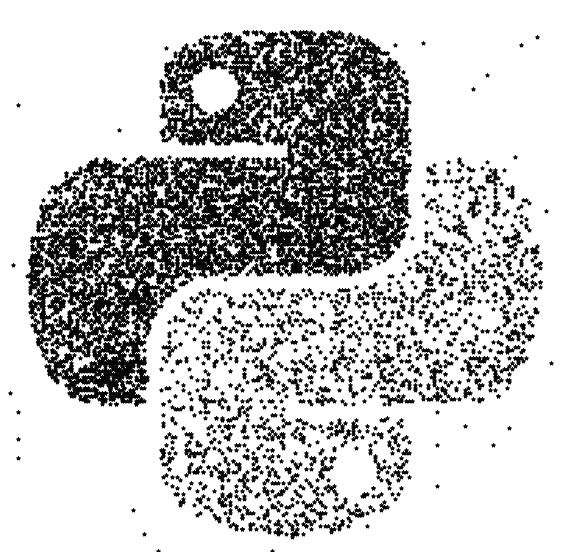

In [11]:
input_path = 'python.png'
output_path = 'python.gif'

approach = 'rs'  # sampling method, 'default'=pymc3 metropolis, 'rs'=rejection sampling, 'gibbs'=gibbs sampling
threshold = 0.1  # image preprocessing, turns light gray into white and dark gray into black -> better initialization
nchains = 4
samples = 10000
marker = '*'
markersize = 4
leading_point =  True  # bool, if True current sampled point has a bigger marker
interval = 30
colors = ['#010101', '#FF0000', '#FFFF00', '#00FF00']

main(input_path=input_path,
             output_path=output_path,
             nchains=nchains,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors,
             approach=approach,
             threshold=threshold)


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [image]


Sampling 4 chains for 100 tune and 10_000 draw iterations (400 + 40_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
MovieWriter imagemagick unavailable; using Pillow instead.


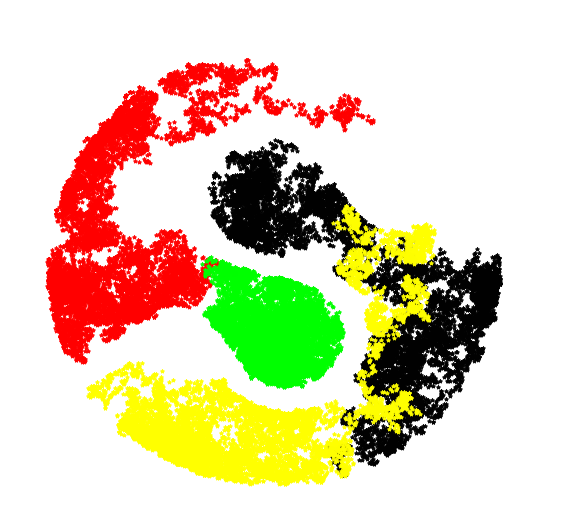

In [7]:
main(input_path='scipy.png',
             output_path='scipy.gif',
             nchains=nchains,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors,
             approach='default',
             threshold=threshold)


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [image]


Sampling 4 chains for 100 tune and 10_000 draw iterations (400 + 40_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
MovieWriter imagemagick unavailable; using Pillow instead.


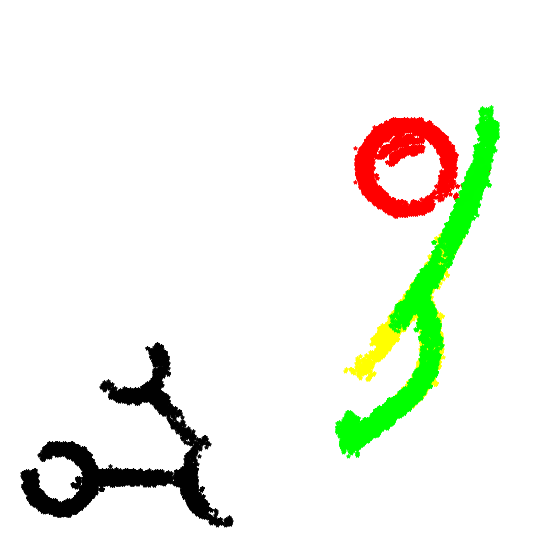

In [9]:
main(input_path='pymc3-logo.png',
             output_path='pymc3-logo.gif',
             nchains=nchains,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors,
             approach='default',
             threshold=threshold)